# Фильтр Калмана
#### Фильтр Калмана
— это хорошо исследованный и популярный метод для включения новой информации из временного ряда и ее разумного объединения с ранее известной информацией для оценки основного состояния. Одно из первых применений фильтра Калмана произошло во время миссии Apollo 11: когда инженеры НАСА поняли, что встроенные вычислительные элементы не позволят использовать другие, более ресурсоемкие методы оценки положения, они выбрали этот фильтр. Как вы увидите в этом разделе, преимущества фильтра Калмана заключаются в том, что его относительно легко вычислить, и он не требует хранения прежних данных для составления текущих оценок или будущих прогнозов.


#### Код реализации фильтра Калмана
Рассмотрим классический вариант использования фильтра Калмана: попробуем отследить объект, подчиняющийся законам Ньютона, с помощью датчиков, передающих показания с некой ошибкой. Сгенерируем временные ряды, основываясь на ньютоновских законах движения тел, согласно которым положение объекта является функцией его скорости и ускорения. Несмотря на непрерывность физического процесса, движение будет отслеживаться по данным дискретных измерений. В самом начале создадим ряд со значениями ускорения, а затем предположим, что начальные положение и скорость объекта равны 0. Хотя это не совсем реалистично, будем предполагать, что ускорение изменяется мгновенно в начале каждого временного шага и остается постоянным в течение всей его длительности.
#### Обзор
Вычислительные методики, применяемые для описания фильтра Калмана, способны озадачить начинающих специалистов по обработке данных — не только исходя из их высокой сложности, но и потому, что в них приходится отслеживать значительное количество величин — это итеративный, отчасти замкнутый процесс со многими взаимосвязанными величинами. По этой причине здесь мы не будем выводить уравнения фильтра Калмана, а всего лишь приведем общее их описание, чтобы понять, как они работаю

In [1]:
## Ракета движется 100 временных шагов
ts.length <- 100
## Движение является ускоренным
a <- rep(0.5, ts.length)
## Начальное положение и скорость равны 0
x <- rep(0, ts.length)
v <- rep(0, ts.length)
for (ts in 2:ts.length) {
  x[ts] <- v[ts - 1] * 2 + x[ts - 1] + 1/2 * a[ts - 1] ^ 2
  x[ts] <- x[ts] + rnorm(1, sd = 20) ## stochastic component
  v[ts] <- v[ts - 1] + 2 * a[ts - 1]
}

Если вы не помните законы Ньютона, то обязательно повторите их, чтобы не принимать на веру все дальнейшие выкладки (в первую очередь, касающиеся вычисления значений х [ts ] и v [ts ]).

Динамические характеристики движения, которое описывается заданными ранее параметрами, показаны на графиках, изображенных на рисунке.


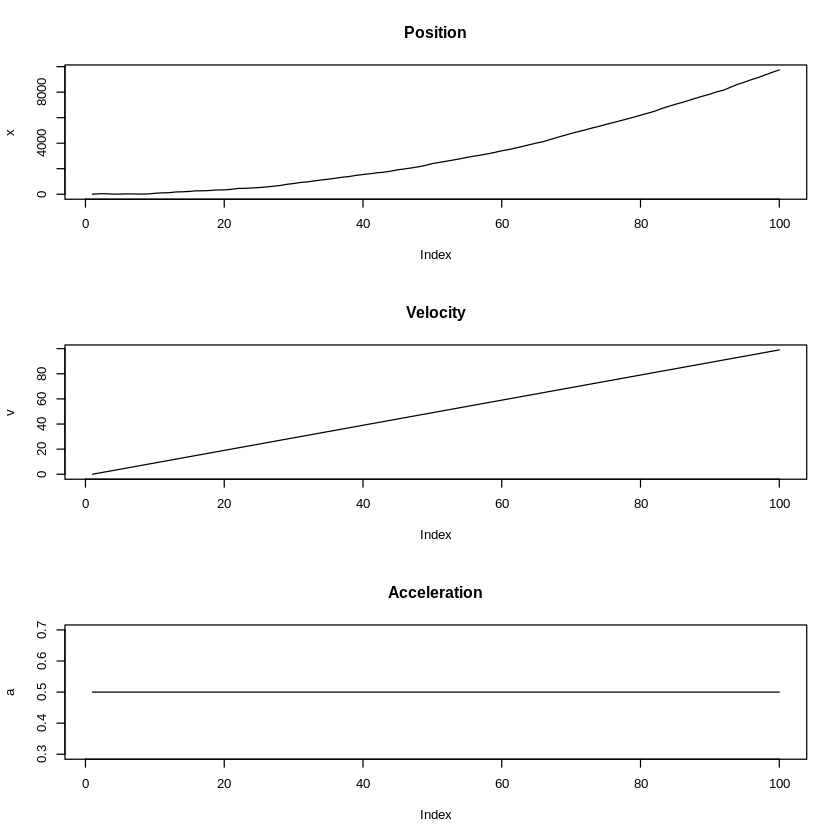

In [2]:
par(mfrow = c(3, 1))
plot(x, main = "Position",     type = 'l')
plot(v, main = "Velocity",     type = 'l')
plot(a, main = "Acceleration", type = 'l')

Предполагается, что переменные полностью описывают состояние, но единственные доступными данные — это сведения о положении объекта, и они поступают с зашумленного датчика. В следующем коде положение такого датчика задается переменной х, а измеренные значения соотносятся с фактическими данными о положении объекта так, как показано на рисунке.

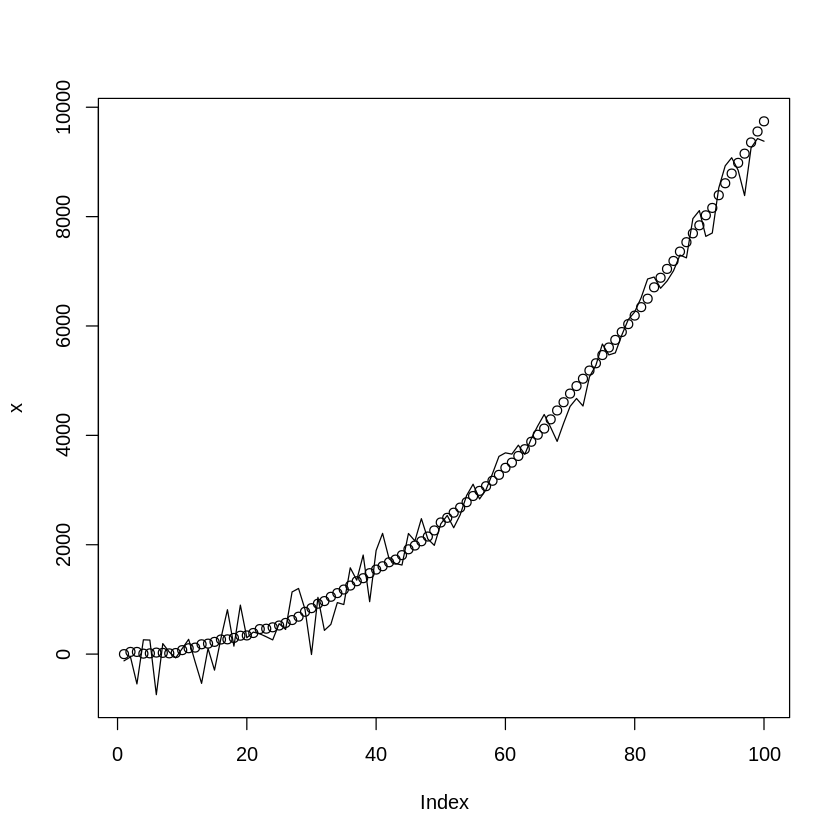

In [3]:
z <- x + rnorm(ts.length, sd = 300)
par(mfrow = c(1, 1))
plot(x, ylim = range(c(x, z)))
lines(z)

Как видно на рисунке, движение характеризуется постоянным ускорением (нижний график), обеспечивающим линейное увеличение
скорости (средний график) и изменение координаты по параболической траектории (верхний график).
Если такое поведение объекта кажется вам непонятным, то либо примите его как должное, либо повторите курс механики в
любом учебнике по физике. Применим фильтр Калмана. Сначала напишем общую функцию, отражающую параметризацию системы и
результаты, полученные ранее в этом разделе.


In [4]:
kalman.motion <- function(z, Q, R, A, H) {
  dimState = dim(Q)[1]

  xhatminus <- array(rep(0, ts.length * dimState),
                     c(ts.length, dimState))
  xhat      <- array(rep(0, ts.length * dimState),
                     c(ts.length, dimState))

  Pminus  <- array(rep(0, ts.length * dimState * dimState),
                   c(ts.length, dimState, dimState))
  P       <- array(rep(0, ts.length * dimState * dimState),
                   c(ts.length, dimState, dimState))

  K <- array(rep(0, ts.length * dimState),
             c(ts.length, dimState)) # коэффициент усиления Калмана

# Начальное предположение о равенстве нулю всех параметров
  xhat[1, ] <- rep(0, dimState)
  P[1, , ]  <- diag(dimState)

  for (k in 2:ts.length) {
    # Обновление времени
    xhatminus[k, ] <- A %*% matrix(xhat[k-1, ])
    Pminus[k, , ] <- A %*% P[k-1, , ] %*% t(A) + Q

    K[k, ] <- Pminus[k, , ] %*% H %*%
                            solve( t(H) %*% Pminus[k, , ] %*% H + R )
    xhat[k, ] <- xhatminus[k, ] + K[k, ] %*%
                            (z[k] - t(H) %*% xhatminus[k, ])
    P[k, , ] <- (diag(dimState) - K[k, ] %*% t(H)) %*% Pminus[k, , ]
  }
## Возвращение прогноза и сглаженного значения
  return(list(xhat = xhat, xhatminus = xhatminus))
}

Теперь применим эту функцию для определения одного только положения (но не ускорения и скорости) ракеты.

In [5]:
## Параметры шума
R <- 10^2 	## Дисперсия измерений. Предопределяется физическими
            ## ограничениями, накладываемыми на измерительное
            ## оборудование. Согласуется с шумом, добавленным к х,
            ## в представленном выше коде
Q <- 10 	## Дисперсия процесса. Обычно это гиперпараметр,
            ## обеспечивающий наибольшую точность


In [6]:
## Динамические параметры
A <- matrix(1) ## x_t = А * x_t-l (как предыдущее значение х влияет на последующее значение х)
H <- matrix(1) ## y_t = Н * x_t (перевод состояния в измерение)
## Прогонка данных через фильтр Калмана
xhat <- kalman.motion(z, diag(1) * Q, R, A, H)[[1]]
xhatminus <- kalman.motion(z, diag(1) * Q, R, A, H)[[2]]

Представим реальные, измеренные и прогнозируемые положения на общем графике.


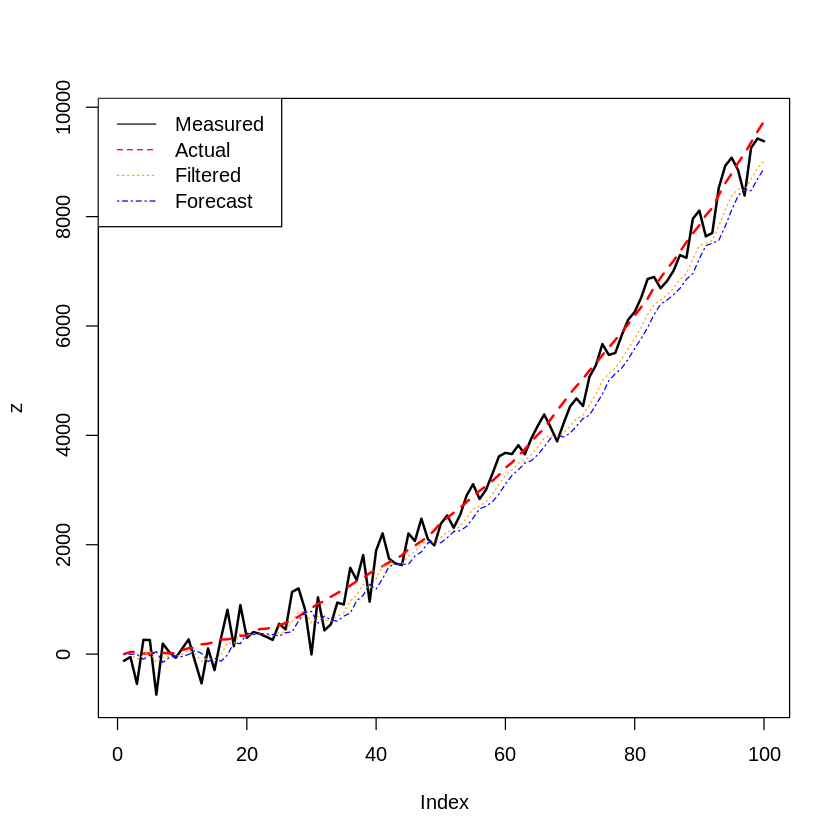

In [7]:
## visualization
plot(z, ylim = range(c(x, z)), type = 'l',
                 col = "black",  lwd = 2)
lines(x,         col = "red",    lwd = 2, lty = 2)
lines(xhat,      col = "orange", lwd = 1, lty = 3)
lines(xhatminus, col = "blue",   lwd = 1, lty = 4)
legend("topleft",
       legend = c("Measured", "Actual", "Filtered", "Forecast"),
       col = c("black", "red", "orange", "blue"),
       lty = 1:4)

Фильтр Калмана удаляет большую часть шума из ошибки измерения. Насколько много — зависит от значения R, параметра шума измерения, который отражает способность фильтра взвешивать последнее значение по сравнению с более ранними значениями. Как видим, фильтр вполне удовлетворительно справляется с прогнозированием данных. В частности, между прогнозными и фактическими данными не наблюдается запаздывание, а это указывает, что прогноз текущего значения строится на основе последнего значения.
    Мы рассмотрели самый простой пример фильтра Калмана. Он хорошо исследован и находит широкое применение в различных приложениях, особенно в системах с неплохо изученной внутренней динамикой. Это делает его идеальным инструментом для решения задач, подобных простому движению ракеты, с достаточно точно изученными процессами изменения системы.
    Обратите внимание на то, что в этом простом примере возможности и преимущества фильтра Калмана раскрыты не полностью. В общем случае он оказывается полезным при решении задач с несколькими типами измерений — разных величин или параллельных измерений одного и того же показателя несколькими устройствами. Существует множество вариантов фильтра Калмана, имеющих большое прикладное значение в самых разных дисциплинах и областях знаний. Как было показано выше, одно из главных преимуществ фильтра Калмана заключается в его рекурсивности. Это устраняет необходимость в просмотре всех предыдущих точек данных в каждой итерации процесса. Скорее, на каждом временном шаге вся информация из предыдущих временных шагов оптимальным образом включается в несколько оценочных параметров, а именно — в последние оценки состояния и ковариации. К достоинствам метода стоит отнести взвешенное обновление данных, когда сводные статистические значения исследуемых показателей оптимально сопоставляются только с последними данными.


   Такой подход делает фильтр Калмана наиболее востребованным в приложениях, где наибольшую ценность представляют вычислительная производительность и скорость обработки данных. Во многих случаях он прекрасно описывает динамику реальных систем, представляемых с помощью Марковских процессов (хранящими сведения только о предыдущих состояниях) и функции базового состояния, которое может быть измерено только с некоторой ошибкой.
    Существует много полезных модификаций рассмотренного выше фильтра Калмана. Один из наиболее распространенных его вариантов отличается адаптацией к сглаживанию — возможностью получить наилучшую оценку истинного состояния в момент времени t на основе данных как до, так и после времени t. Математические уравнения и код реализации такого подхода во многом схожи с представленными выше. Еще один вариант — расширенный фильтр Калмана (Extended Kalman Filter — EKF), в котором фильтр Калмана адаптируется к данным процессов с нелинейной динамикой. Его достаточно просто реализовать благодаря включению специальных инструментов в различные пакеты языков R и Python.
    Сложность фильтра Калмана составляет О(Т) относительно длины временного ряда и O(d2) — относительно d, размерности состояния. Это указывает на то, что нужно отказываться от переопределения состояния в случаях, когда более упорядоченная спецификация уже работает хорошо. Однако именно линейность по отношению к длине временных рядов делает фильтр Калмана широко используемым в реальных производственных задачах и гораздо более популярным, чем другие фильтры, предназначенные для моделирования пространств состояний временных рядов.


# Скрытые марковские модели
Скрытые марковские модели (Hidden Markov Models — HMM) — это особенно полезное и интересное средство моделирования временных рядов, представляющее в анализе временных рядов редкий случай обучения без учителя, в котором обучение ведется в отсутствие обозначенного правильного ответа. Модели НММ обосновываются исходя из интуитивных соображений, подобных используемым при описании фильтра Калмана ранее в этой главе, — предположении о том, что наблюдаемые переменные могут быть не самыми информативными для рассматриваемой системы. Как и в случае фильтра Калмана, примененного к линейной гауссовой модели, будем полагать, что процесс имеет состояния, а наблюдения предоставляют информацию о таких состояниях. Как и прежде, нам нужно получить представление о том, как переменные состояния связаны с проведенными наблюдениями. В случае применения НММ утверждается, что процесс нелинейный и характеризуется скачками между дискретными состояниями.


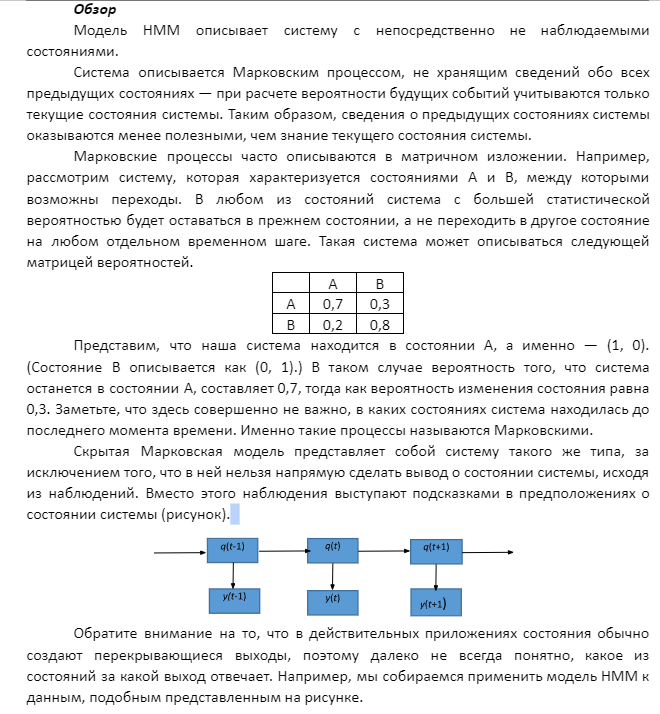<

#### Обучение модели
Мы утверждаем, что существует состояние, которое невозможно измерить напрямую, и во многих наборах данных, к которым можно было бы применить метод, невозможно определить их визуально. Тогда как нужно действовать, чтобы распознать скрытые состояния, не обладая априорными знаниями о них? Ответ: проходом по состояниям. Не существует волшебной палочки для получения наиболее вероятной последовательности скрытых состояний для объяснения наблюдений, но всегда можно провести их оценку, правильно описав систему.
В модели НММ утверждается, что система полностью описывается при наличии следующей информации.
• Вероятность перехода от х(t) к x(t + 1). Задается с помощью матрицы, аналогичной описанной выше и устанавливающей вероятности переходов между состояниями А и В. Размер такой матрицы зависит от количества гипотетических состояний.
• Вероятность эмиссии, или вероятность наблюдения y(t) при заданном значении x(t).
• Начальное состояние системы.
Рассмотрим конкретный случай, в котором обозначим переменные, принимающие участие в определении и обучении НММ-процесса.
• Q = q1, q2, ..., qN различных состояний системы.
• А = аi,j = а1,1, а1,2, ..., aN,N — матрица вероятностей перехода, определяющая переход на любом заданном временном шаге из состояния i в состояние j.
• О = o1, о2, ..., оТ — последовательность наблюдений, отобранных из этого процесса в порядке следования, т.е. временного ряда наблюдений.
• bj(ot) (вероятность эмиссии (вероятность наблюдения данного значения, оt если состояние qj).
• p = p1, p2,…,pN - начальные распределения вероятностей, а именно — вероятность того, что система имеет начальное состояние q1, q2,…,qN соответственно.
Однако в реальных данных обычно ни одна из этих переменных не определена. Чаще всего изначально известна только фактическая последовательность наблюдаемых значений y1, y2,…,yt.


#### Алгоритм Баума-Уэлча
Для оценки параметров скрытой марковской модели воспользуемся алгоритмом Баума-Уэлча. Он сводится к решению сложной задачи — оценке значений всех параметров, подробно описанных в предыдущем разделе. Это очень многогранная задача. Разобьем ее на следующие подзадачи.
• Определение вероятностей эмиссии для каждого возможного скрытого состояния и перехода из каждого возможного скрытого состояния в другое возможное скрытое состояние. Используем алгоритм Баума-Уэлча.
• Определение наиболее вероятного скрытого состояния на каждом временном шаге с учетом всей истории наблюдений. Используем алгоритм Витерби (описан ниже). Это родственные задачи, каждая из которых достаточно сложна и требует для решения больших вычислительных затрат. Более того, они связаны одна с другой. Для решения двух взаимосвязанных задач — оценки параметров и максимизации вероятности — можно использовать алгоритм максимизации математического ожидания для перехода между этими двумя этапами, пока не будет найдено приемлемое решение.
Чтобы применить алгоритм Баума-Уэлча, первым делом нужно определить функцию правдоподобия, которая представляет вероятность наблюдения имеющейся последовательности при заданных гипотетических параметрах. В нашем случае такими предполагаемыми параметрами будут математические параметры для каждого постулируемого состояния.
Например, предположим, что состояния описываются гауссовыми выходными данными с различными средними значениями и стандартными отклонениями в наблюдаемых значениях, зависящими от состояния. Рассмотрим модель с двумя такими состояниями, которую будем описывать в терминах μ1, σ1 и μ2, σ2, где μu=i обозначает среднее значение i-го состояния, σi — стандартное отклонение i –го состояния. С их помощью рассчитываются вероятности эмиссии, все вместе обозначаемые как θ. Кроме того, нам нужно обозначить последовательность состояний x1, x2,…,xt  (все вместе Xt), которые нами не наблюдаются, но давайте представим, что они все же существуют.
Функция правдоподобия такой системы должна описывать вероятность наблюдения существующей последовательности при заданных параметрах вероятности эмиссии (т.е. вероятности наблюдения в строго заданном состоянии) и последовательности скрытых состояний как интеграла по всем возможным Xt таких что:
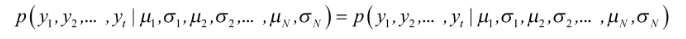
Однако это сложная задача по нескольким причинам, включая факт ее экспоненциального усложнения с увеличением количества временных шагов, что указывает на невозможность проведения исчерпывающего анализа по перекрывающимся значениям. Следовательно, нам нужно упростить задачу, обратившись к следующему


#### ЕМ-алгоритму.
1. Произвольно инициализируем переменные вероятности эмиссии.
2. Вычисляем вероятность каждого возможного Xt, учитывая значения вероятности эмиссии.
3. Используем эти значения Xt, чтобы получить лучшую оценку переменных вероятности эмиссии.
4. Повторяем пп. 2 и 3 до тех пор, пока не будет достигнута сходимость.
Более неформально это означает, что при случайном размещении двух распределений мы будем рассматривать каждый временной шаг и определять на каждом из них вероятность наблюдения определенного состояния (например, состояния А или В на временном шаге t). Назначив предполагаемое состояние для каждого временного шага, используем эти метки для переоценки вероятностей эмиссии (обнуляя лучшие среднее и стандартное отклонение для состояния). Затем процесс нужно повторить заново, используя недавно обновленные переменные вероятности эмиссии для улучшения оценки траектории Xt.
Не забывайте, что найти оптимальный набор параметров в таком способе использования ЕМ-алгоритма удается далеко не всегда. Может понадобиться много попыток, прежде чем вы добьетесь успеха, — продолжительность операции зависит от конкретных данных и выбранной модели.

#### Алгоритм Витерби
После оценки параметров процесса НММ, например, с помощью алгоритма Баума - Уэлча, нужно выполнить следующую, не менее важную задачу, заключающуюся в определении наиболее вероятного ряда состояний, основанных на временном ряду наблюдаемых значений.
В отличие от алгоритма Баума-Уэлча алгоритм Витерби гарантированно предоставляет наилучшее решение поставленной выше задачи. А все потому, что он относится к алгоритмам динамического программирования, предназначенным для полного и эффективного изучения диапазона возможных совпадений методом сохранения решений, полученных для отдельных участков пути, что позволяет отказаться от повторного пересчета всех возможных вариантов в случае удлинения пути.


#### Динамическое программирование
Специалисты по анализу данных не всегда располагают полным набором алгоритмов, но при изучении временных рядов точно не смогут обойтись без базовых решений, в которых предположения и повторное рассмотрение выступают необычайно важными техниками исследования упорядоченных во времени данных.
Проще всего объяснить, что такое динамическое программирование, на уже ставшем классическим примере последовательности чисел Фибоначчи. Представьте, что вам требуется вычислить восьмое число Фибоначчи. Проще всего получить его, зная шестое и седьмое числа последовательности Фибоначчи. А чтобы получить их, нужны четвертое и пятое числа Фибоначчи и т.д. Таким образом, решение более сложных задач по вычислению последовательностей Фибоначчи основывается на результатах более простых таких задач. Следовательно, при вычислении чисел Фибоначчи их нужно как-то сохранять, чтобы иметь возможность использовать в последующих, еще более сложных задачах. По этой причине динамическое программирование также известно как мемоизация.
Динамическое программирование применяется для решения задач со следующими отличительными признаками.
• Решение задачи размера N можно основать на решении задачи размера N - 1. По этой причине мемоизация решений более ранних, простых задач помогает более эффективно решать более поздние, заведомо более сложные задачи.
• Задачи имеют явно выраженный порядок масштабирования от более простой к более сложной.
• Всегда можно выделить базовую задачу, подлежащую простому расчету.



### Код обучения модели НММ
Хотя процесс обучения модели НММ очень сложен, он реализуется с помощью специализированных пакетов языка R очень просто. В следующем примере используются инструменты пакета depmixS4. Вначале нужно получить надлежащий временной ряд. Воспользуемся следующим кодом.


In [8]:
## Обратите внимание: здесь задается начальное значение
## При одном и том же начальном значении числа должны совпадать
set.seed (123)
## Параметры распределения для всех четырех состояний рынка,
## подлежащих моделированию
bull_mu <- 0.1
bull_sd <-0.1

neutral_mu <- 0.02
neutral_sd <- 0.08

bear_mu <- -0.03
bear_sd <- 0.2

panic_mu <- -0.1
panic_sd <- 0.3


In [9]:
## Представление параметров векторами для упрощения индексации
mus <- c(bull_mu, neutral_mu, bear_mu, panic_mu)
sds <- c(bull_sd, neutral_sd, bear_sd, panic_sd)


In [10]:
## Константы, описывающие генерируемые временные ряды
NUM.PERIODS <- 10
SMALLEST.PERIOD <- 20
LONGEST.PERIOD <- 40


In [11]:
## Определение рыночных дней случайным образом.
## Каждый такой день соответствует отдельному состоянию рынка
days <- sample (SMALLEST.PERIOD:LONGEST.PERIOD, NUM.PERIODS,
replace = TRUE)
## Генерирование временного ряда состояний рынка для заданного
## количества дней и его добавление к общему временному ряду
returns <- numeric ()
true.mean <- numeric()
for (d in days) {
idx = sample(1:4, 1, prob = c(0.2, 0.6, 0.18, 0.02))
returns <- c (returns, rnorm(d, mean = mus [idx], sd = sds [idx]))
true.mean <- c(true.mean, rep(mus [idx], d))
}


В предыдущем коде моделируется процесс биржевой торговли на бычьих, медвежьих, нейтральных и панических рынках. В нем устанавливается случайное количество дней, для которых сохраняются состояния рынка, а также определяются переменные, описывающие распределение вероятности эмиссии для каждого состояния (_mu и sd_, хранящие значения, которые подлежат измерению в заданном состоянии).
Чтобы получить представление о сгенерированном кодом временном ряде и частотности каждого состояния, нужно понять, сколько дней в выборке соответствует
каждому значению переменной true.mean, по которой отслеживаются состояния.


In [12]:
table(true.mean)

true.mean
-0.03  0.02   0.1 
   66   142   111 

Невероятно, но факт! Несмотря на намерение включить четыре состояния в моделируемый ряд, их было добавлено только три. Скорее всего, это связано с очень низкой вероятностью включения (0,02) четвертого состояния. Мы видим, что наименее вероятное состояние даже не было выбрано для добавления в ряд. Таким образом, далеко не всегда известно, что для заданного временного ряда учитываются не все возможные состояния, что еще раз свидетельствует о высокой сложности алгоритма модели НММ и сложности его обучения. Как бы там ни было, дальнейший анализ будет выполнен для группы из четырех состояний, чтобы увидеть, к какому результату это приведет (обратите внимание, что еще одна проблема с моделируемыми данными заключается в том, что мы не создали матрицу вероятности перехода из одного состояния в другое для управления потоком скрытого состояния. По сути, мы предположили, что состояние с большей вероятностью останется таким, как есть, в течение многих дней подряд, а затем с равной вероятностью сменится любым другим состоянием. Мы упустили формальную спецификацию и отказались от использования матрицы переходов для упрощения кода).

Можно переходить к обучению НММ. Результирующая модель НММ будет представлять временные ряды апостериорных вероятностей для каждого состояния для любого количества указанных состояний. В соответствии с более ранним описанием ЕМ-алгоритма от нас требуется указать всего одно значение — число предполагаемых состояний. Остальные параметры будут определяться по мере выполнения вычислительных этапов.
Как это часто бывает, при работе с программными пакетами наиболее сложная часть анализа на самом деле оказывается очень простой в реализации и представлении в коде. В нашем случае используется пакет depmixS44 (название этого пакета заимствовано у альтернативного названия “НММ” — Dependent Mixture Models (Модель зависимых смесей)) языка R. Обучение модели проводится дважды. Во-первых, с помощью функции depmix(), в которой устанавливается ожидаемое распределение, указываются число состояний и входные данные, которые будут использоваться при обучении. Далее в действие вступает функция fit(), которая принимает в качестве входных данных спецификацию модели. И только после этого применяется функция posterior(), генерирующая апостериорное распределение подписей состояний с учетом соответствия данных. Начиная с этого момента модель считается обученной, и нам остается только решить задачу по разметке данных, чтобы оценить параметры, описывающие распределения состояний и вероятности переходов.


In [13]:
install.packages("depmixS4")
library(depmixS4)
require (depmixS4)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘truncnorm’, ‘Rsolnp’


Loading required package: nnet

Loading required package: MASS

Loading required package: Rsolnp

Loading required package: nlme



In [14]:
hmm.model <- depmix(returns ~ 1, family = gaussian(), nstates = 4, data=data.frame(returns=returns))
model.fit <- fit(hmm.model)
post_probs <- posterior(model.fit)


converged at iteration 357 with logLik: 265.7247 


Warning message in .local(object, ...):
“Argument 'type' not specified and will default to 'viterbi'. This default may change in future releases of depmixS4. Please see ?posterior for alternative options.”


тим кодом создается модель hmm.model, в которой в качестве наблюдаемого указывается вектор returns. В нем определяется число состояний (4) и соответствие вероятности эмиссии нормальному распределению (см. параметр family). Модель обучается с помощью функции fit(), а для вычисления апостериорных вероятностей применяется функция posterior(). Апостериорные вероятности определяют правдоподобие состояний в данное время для параметров модели, определенных в процессе обучения.


Теперь можно переходить к визуализации состояний на одном графике с измеренными значениями.

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

[[9]]
NULL

[[10]]
NULL

[[11]]
NULL

[[12]]
NULL

[[13]]
NULL

[[14]]
NULL

[[15]]
NULL

[[16]]
NULL

[[17]]
NULL

[[18]]
NULL

[[19]]
NULL

[[20]]
NULL

[[21]]
NULL

[[22]]
NULL

[[23]]
NULL

[[24]]
NULL

[[25]]
NULL

[[26]]
NULL

[[27]]
NULL

[[28]]
NULL

[[29]]
NULL

[[30]]
NULL

[[31]]
NULL

[[32]]
NULL

[[33]]
NULL

[[34]]
NULL

[[35]]
NULL

[[36]]
NULL

[[37]]
NULL

[[38]]
NULL

[[39]]
NULL

[[40]]
NULL

[[41]]
NULL

[[42]]
NULL

[[43]]
NULL

[[44]]
NULL

[[45]]
NULL

[[46]]
NULL

[[47]]
NULL

[[48]]
NULL

[[49]]
NULL

[[50]]
NULL

[[51]]
NULL

[[52]]
NULL

[[53]]
NULL

[[54]]
NULL

[[55]]
NULL

[[56]]
NULL

[[57]]
NULL

[[58]]
NULL

[[59]]
NULL

[[60]]
NULL

[[61]]
NULL

[[62]]
NULL

[[63]]
NULL

[[64]]
NULL

[[65]]
NULL

[[66]]
NULL

[[67]]
NULL

[[68]]
NULL

[[69]]
NULL

[[70]]
NULL

[[71]]
NULL

[[72]]
NULL

[[73]]
NULL

[[74]]
NULL

[[75]]
NULL

[[76]]
NULL

[[77]]
NULL

[[78]]
NULL

[[79]]
NULL

[[80]]
NULL

[[81]]
NULL

[[82]]
NULL

[[83]]
NULL

[[84]]
NULL

[[85]]
NULL

[[86]]
NULL

[[87]]
NULL

[[88]]
NULL

[[89]]
NULL

[[90]]
NULL

[[91]]
NULL

[[92]]
NULL

[[93]]
NULL

[[94]]
NULL

[[95]]
NULL

[[96]]
NULL

[[97]]
NULL

[[98]]
NULL

[[99]]
NULL

[[100]]
NULL

[[101]]
NULL

[[102]]
NULL

[[103]]
NULL

[[104]]
NULL

[[105]]
NULL

[[106]]
NULL

[[107]]
NULL

[[108]]
NULL

[[109]]
NULL

[[110]]
NULL

[[111]]
NULL

[[112]]
NULL

[[113]]
NULL

[[114]]
NULL

[[115]]
NULL

[[116]]
NULL

[[117]]
NULL

[[118]]
NULL

[[119]]
NULL

[[120]]
NULL

[[121]]
NULL

[[122]]
NULL

[[123]]
NULL

[[124]]
NULL

[[125]]
NULL

[[126]]
NULL

[[127]]
NULL

[[128]]
NULL

[[129]]
NULL

[[130]]
NULL

[[131]]
NULL

[[132]]
NULL

[[133]]
NULL

[[134]]
NULL

[[135]]
NULL

[[136]]
NULL

[[137]]
NULL

[[138]]
NULL

[[139]]
NULL

[[140]]
NULL

[[141]]
NULL

[[142]]
NULL

[[143]]
NULL

[[144]]
NULL

[[145]]
NULL

[[146]]
NULL

[[147]]
NULL

[[148]]
NULL

[[149]]
NULL

[[150]]
NULL

[[151]]
NULL

[[152]]
NULL

[[153]]
NULL

[[154]]
NULL

[[155]]
NULL

[[156]]
NULL

[[157]]
NULL

[[158]]
NULL

[[159]]
NULL

[[160]]
NULL

[[161]]
NULL

[[162]]
NULL

[[163]]
NULL

[[164]]
NULL

[[165]]
NULL

[[166]]
NULL

[[167]]
NULL

[[168]]
NULL

[[169]]
NULL

[[170]]
NULL

[[171]]
NULL

[[172]]
NULL

[[173]]
NULL

[[174]]
NULL

[[175]]
NULL

[[176]]
NULL

[[177]]
NULL

[[178]]
NULL

[[179]]
NULL

[[180]]
NULL

[[181]]
NULL

[[182]]
NULL

[[183]]
NULL

[[184]]
NULL

[[185]]
NULL

[[186]]
NULL

[[187]]
NULL

[[188]]
NULL

[[189]]
NULL

[[190]]
NULL

[[191]]
NULL

[[192]]
NULL

[[193]]
NULL

[[194]]
NULL

[[195]]
NULL

[[196]]
NULL

[[197]]
NULL

[[198]]
NULL

[[199]]
NULL

[[200]]
NULL

[[201]]
NULL

[[202]]
NULL

[[203]]
NULL

[[204]]
NULL

[[205]]
NULL

[[206]]
NULL

[[207]]
NULL

[[208]]
NULL

[[209]]
NULL

[[210]]
NULL

[[211]]
NULL

[[212]]
NULL

[[213]]
NULL

[[214]]
NULL

[[215]]
NULL

[[216]]
NULL

[[217]]
NULL

[[218]]
NULL

[[219]]
NULL

[[220]]
NULL

[[221]]
NULL

[[222]]
NULL

[[223]]
NULL

[[224]]
NULL

[[225]]
NULL

[[226]]
NULL

[[227]]
NULL

[[228]]
NULL

[[229]]
NULL

[[230]]
NULL

[[231]]
NULL

[[232]]
NULL

[[233]]
NULL

[[234]]
NULL

[[235]]
NULL

[[236]]
NULL

[[237]]
NULL

[[238]]
NULL

[[239]]
NULL

[[240]]
NULL

[[241]]
NULL

[[242]]
NULL

[[243]]
NULL

[[244]]
NULL

[[245]]
NULL

[[246]]
NULL

[[247]]
NULL

[[248]]
NULL

[[249]]
NULL

[[250]]
NULL

[[251]]
NULL

[[252]]
NULL

[[253]]
NULL

[[254]]
NULL

[[255]]
NULL

[[256]]
NULL

[[257]]
NULL

[[258]]
NULL

[[259]]
NULL

[[260]]
NULL

[[261]]
NULL

[[262]]
NULL

[[263]]
NULL

[[264]]
NULL

[[265]]
NULL

[[266]]
NULL

[[267]]
NULL

[[268]]
NULL

[[269]]
NULL

[[270]]
NULL

[[271]]
NULL

[[272]]
NULL

[[273]]
NULL

[[274]]
NULL

[[275]]
NULL

[[276]]
NULL

[[277]]
NULL

[[278]]
NULL

[[279]]
NULL

[[280]]
NULL

[[281]]
NULL

[[282]]
NULL

[[283]]
NULL

[[284]]
NULL

[[285]]
NULL

[[286]]
NULL

[[287]]
NULL

[[288]]
NULL

[[289]]
NULL

[[290]]
NULL

[[291]]
NULL

[[292]]
NULL

[[293]]
NULL

[[294]

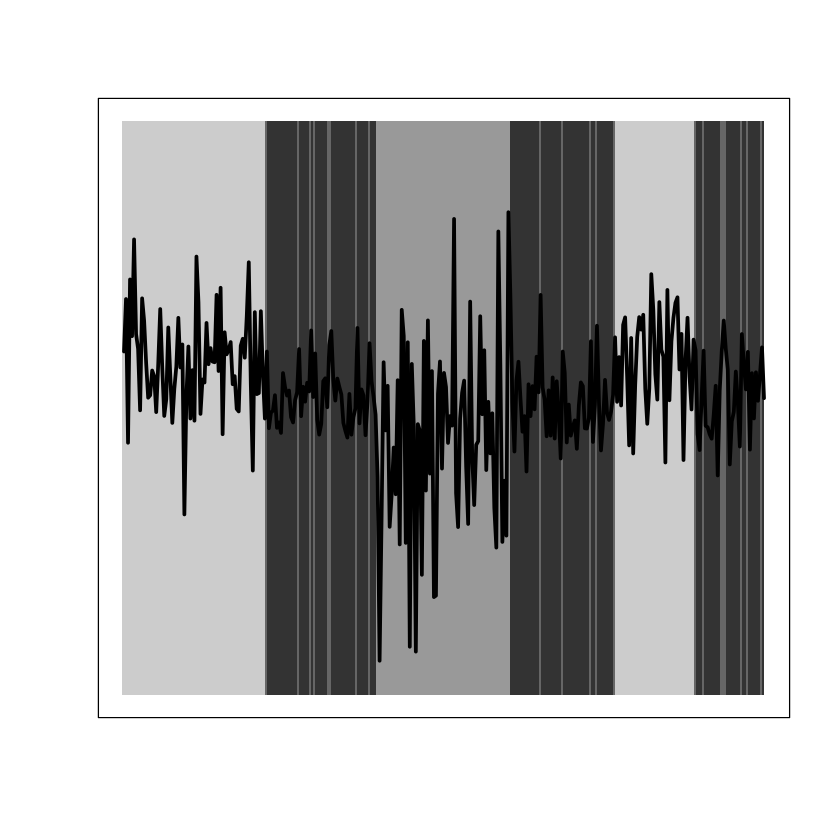

In [15]:
plot (returns, type = 'l', lwd = 3, col = 1,
yaxt = "n", xaxt = "n", xlab = " ", ylab =" ",
ylim = c(-0.6, 0.6))
lapply(0:(length(returns) - 1), function (i) {
## Добавление прямоугольника соответствующего цвета,
## обозначающего состояние в заданный момент времени
rect (i,-0.6, (i + 1),0.6,
col = rgb(0.0,0.0,0.0,alpha=(0.2 * post_probs$state[i + 1])),
border = NA)
}
)

Сведения о предполагаемых параметрах распределения хранятся в отдельных атрибутах. При их просмотре помните об исходных настройках генерации данных.


In [16]:
Bull_mu <-    0.1
bull_sd <-      0.1

neutral_mu <-   0.02
neutral_sd <-    0.08

bear_mu <-    -0.03
bear_sd <-      0.2

panic_mu <-   -0.1
panic_sd <-     0.3


Попытавшись сравнить состояния, фактически обозначенные в данных (режим паники на бирже исключен из данных), можно получить представление о корреляции между следующими группами.


In [17]:
attr(model.fit,"response")

[[1]]
[[1]][[1]]
Model of type gaussian (identity), formula: returns ~ 1
Coefficients: 
(Intercept) 
 0.09774445 
sd  0.1040073 


[[2]]
[[2]][[1]]
Model of type gaussian (identity), formula: returns ~ 1
Coefficients: 
(Intercept) 
 -0.0610505 
sd  0.2018184 


[[3]]
[[3]][[1]]
Model of type gaussian (identity), formula: returns ~ 1
Coefficients: 
(Intercept) 
  0.1412881 
sd  0.03796197 


[[4]]
[[4]][[1]]
Model of type gaussian (identity), formula: returns ~ 1
Coefficients: 
(Intercept) 
0.001911518 
sd  0.05601123 



Одна из возможных причин, по которым обучение не привело к хорошему согласованию с базовыми скрытыми состояниями, заключается в отказе от использования правильной матрицы переходов, необходимой для обучения. В результате переходы между состояниями не были Марковскими, и это оказало пагубное влияние на обучение. Кроме того, мы пытались приблизить относительно короткий временной ряд с небольшим количеством переходов между состояниями, в то время как модели НММ лучше работают на более длинных временных рядах с большим количеством переходов. Я бы рекомендовал придумать более реалистичные искусственные данные для тестирования предлагаемой модели НММ. Помните, что в большинстве практических задач приходится работать с ненаблюдаемыми состояниями, поэтому перед тем как взяться за более амбициозные проекты, постарайтесь разобраться в факторах, вносящих ограничения в точность модели, в предельно простых случаях (с искусственными данными).
Модели НММ подходят для анализа многих видов данных. Они использовались для моделирования поведения финансовых рынков в фазе роста и рецессии, определения стадии скручивания белка в клетках и описания перемещения людей (до появления глубокого изучения). На сегодняшний день они остаются востребованными — чаще в задачах исследования динамического поведения систем, чем прогнозирования. Кроме того, модели НММ предоставляют больше сведений о процессах, чем точечные оценки или прогнозы. В такую модель легко включить априорные знания или предположения, например, указав количество состояний, используемых для ее обучения. Тем самым обеспечиваются преимущества статистических методов, но сохраняется возможность параметризации априорных знаний о системе.
Математические принципы и уравнения, используемые для расчета моделей НММ, хорошо изучены и доступны для понимания. На ваше рассмотрение предлагается большое количество программных инструментов и численных алгоритмов оптимизации, используемых при обучении моделей НММ по данным. Вы также познакомитесь с методами динамического программирования, с которыми нужно быть на “ты” каждому специалисту по анализу данных или программисту.
Как и фильтры Калмана, модели НММ могут использоваться для решения задач самых разных типов. На самом деле количество задач логического вывода, связанных с НММ-системами, увеличивается с повышением сложности дискретных состояний, каждое из которых имеет собственную вероятность эмиссии. Перечислим некоторые из задач логического вывода, с которыми вы можете столкнуться при использовании моделей НММ.
• Определение наиболее вероятного описания состояний, производящих ряд наблюдений. Включает в себя оценку вероятностей эмиссии этих состояний, а также матрицы переходов, которая показывает вероятность перехода процесса из одного состояния в другое. Мы проделали это выше, хотя и не задавали вероятности перехода в явном виде.
• Определение наиболее вероятной последовательности состояний с учетом ряда наблюдений и описания состояний, а также вероятностей их эмиссии и переходов. Мы также выполнили эту задачу в предыдущем упражнении. Иногда ее называют “наиболее вероятное объяснение”, и для ее решения обычно применяется алгоритм Витерби.
• Фильтрация и сглаживание. В этой ситуации фильтрация будет соответствовать оценке скрытого состояния последнего временного шага с учетом последнего наблюдения. Сглаживание будет соответствовать определению наиболее вероятного распределения скрытого состояния на конкретном временном шаге с учетом наблюдений до, во время и после этого временного шага.

